<h1>Fundamentals of Probabilistic Data Mining</h1>
<h3>Ensimag - Grenoble INP, AA 2017-2018</h3>
<h2>Lab #3</h2>

In [179]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg
import matplotlib as mpl
import itertools
import hmmlearn.hmm as hl
import warnings
warnings.filterwarnings('ignore')

base_dir = "./Unistroke"
output_dir = "Report/img/"
letter = "A"
output_suffix = "merge.txt"

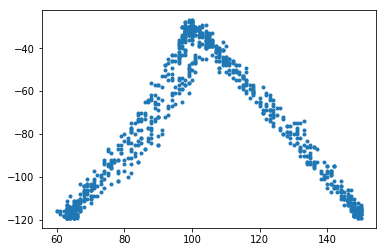

In [180]:
series = np.empty([0, 2])
series_length = np.array([], dtype = int)
filenames = os.listdir(base_dir)
files = [filename for filename in filenames if letter in filename]
for file in files:
    tmp = np.loadtxt(base_dir + "/" + file)[1::]
    series = np.concatenate((series, tmp))
    series_length = np.append(series_length, len(tmp))
    
plt.plot(series[::,0],- series[::,1], '.')
plt.show()

<h4>Question #1: model definition by hand</h4>

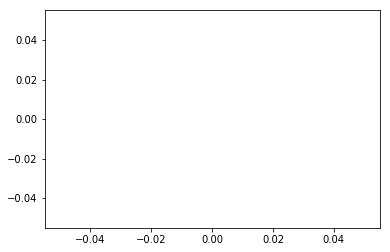

In [181]:
startprob = np.array([1, 0.0, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.0, 1.0, 0.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 0.0, 0.0]])

means = np.array([[60, -120], [100, -30], [150, -120]])
covars = .5 * np.tile(np.identity(2), (3, 1, 1))
#covars = np.zeros((3,3), dtype=int)

# Build an HMM instance and set parameters
model = hl.GaussianHMM(n_components=3, covariance_type="diag")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

for i in range(1, 100):    
    samples, states = model.sample(3)
    plt.plot(samples[::, 0], samples[::, 1])
    
#plt.savefig(output_dir + "modelByHand.pdf")    
plt.show()

<h4>Question #1: Model definition through estimation</h4>

In [182]:
n_states = int(np.ceil(np.mean(series_length)))
hmm = hl.GaussianHMM(n_components = n_states, 
                     covariance_type = 'full', 
                     n_iter = 1000).fit(series, series_length)


In [183]:
for i in range(1, 5):    
    samples, states = hmm.sample(n_states)
    plt.plot(samples[::, 0], -samples[::, 1])

#plt.savefig(output_dir + "modelByEstimation.pdf")    
plt.show()

TypeError: bad operand type for unary -: 'NoneType'

<h4>Real trajectory plot procedure </h4>

In [184]:
def plot_trajectory(trajectory):
    x_points = trajectory[::, 0]
    y_points = trajectory[::, 1]
    index = np.lexsort((y_points, x_points))
    current_series = np.empty([0, 2])
    for i in index:
        current_series = np.concatenate((current_series, np.array([[x_points[i], y_points[i]]])))

    plt.plot(current_series[::, 0], -current_series[::, 1])

<h4>A real trajectory plot</h4>

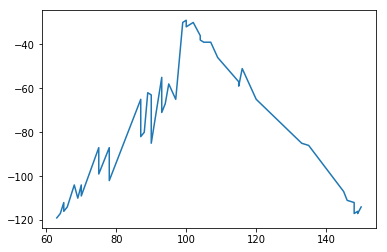

In [185]:
plot_trajectory(series[::series_length[0]])
#plt.savefig(output_dir + "realTrajectory.pdf")    
plt.show()

<h4>All real trajectory plot </h4>

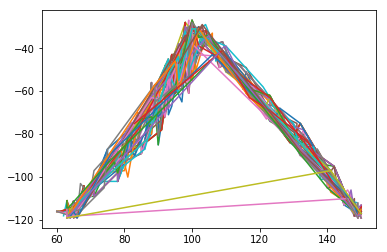

In [186]:
prev = 0
for length in series_length:
    plot_trajectory(series[prev::length])
    prev += length

#plt.savefig(output_dir + "allRealTrajectories.pdf")    
plt.show()

Normalize the trajectories by computing $yt = \dfrac{x_t − x_{t−1}}{|x_t − x_{t−1}|_2}$ for t = 2, . . . , n. Estimate an HMC model with all the normalized trajectories for letter A, using bivariate Gaussian emission distribution. Justify your choice for the number of states. Provide the estimates and comment them.

In [187]:
def get_sample_for_letter(base_dir, letter):
    series = np.empty([0, 2])
    series_length = np.array([], dtype = int)
    filenames = os.listdir(base_dir)
    files = [filename for filename in filenames if letter in filename]
    for file in files:
        tmp = np.loadtxt(base_dir + "/" + file)[1::]
        series = np.concatenate((series, tmp))
        series_length = np.append(series_length, len(tmp))

    plt.plot(series[0,0], series[0,1], '.')
    plt.show()
    return (series, series_length)

In [188]:
def normalize(l):
    l_norm = []
    curr = l[0]
    for i in range(1, len(l)):
        prec = curr
        curr = l[i]
        y = (np.asarray(curr) - np.asarray(prec))/(np.linalg.norm(np.asarray(curr) - np.asarray(prec)))

        if not(np.isnan(y[0])) and not(np.isnan(y[1])):
            l_norm.append(y)
    return (l_norm)

def get_normalized_samples(base_dir, letter, output_dir = "Report/img/"):
    
    series = np.empty([0, 2])
    series_length = np.array([], dtype = int)
    filenames = os.listdir(base_dir)
    files = [filename for filename in filenames if letter in filename]
    x=[]
    y=[]
    for file in files:
        tmp_norm = normalize(np.loadtxt(base_dir + "/" + file)[1::])

        series = np.concatenate((series, tmp_norm))
        series_length = np.append(series_length, len(tmp_norm))
        
        for s in tmp_norm:
            x.append(s[0])
            y.append(s[1])
    
    plt.plot(x, y, '.')
    #plt.savefig(output_dir + "plot_normalized_trajectories_"+letter+".pdf") 
    plt.show()
    return (series, series_length)


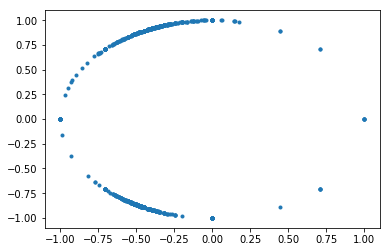

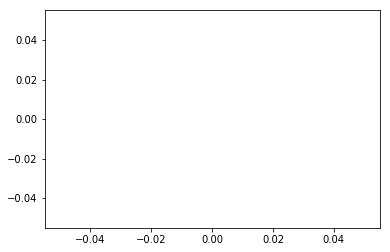

In [189]:
norm_samplesA, norm_lengthA = get_normalized_samples(base_dir, "A")
n_states = int(np.ceil(np.amin(norm_lengthA)))
gaussianHmm = hl.GaussianHMM(n_components=n_states, n_iter=1000).fit(norm_samplesA, norm_lengthA)

s = []
for i in range(0, n_states):
    s.append([])
for i in range(1, 100):    
    samples, states = gaussianHmm.sample(n_states)
    for i in range(0, len(samples)):
        s[i].append(samples[i])

x=[]
y=[]
for i in range(0, len(s)):
    for j in s[i]:
        x.append(j[0])
        y.append(j[1])

plt.plot(x, y, '.')
#plt.savefig(output_dir + "plot_estimated_normalized_trajectories_A_3.pdf")     
plt.show()


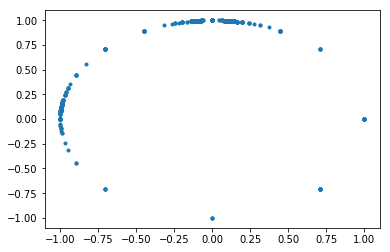

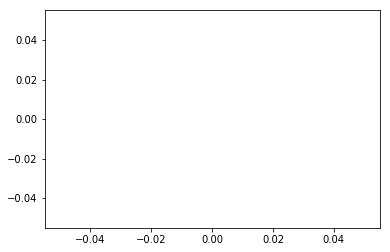

In [190]:
norm_samplesL, norm_lengthL = get_normalized_samples(base_dir, "L")
n_states = int(np.ceil(np.amin(norm_lengthL)))
gaussianHmm = hl.GaussianHMM(n_components=n_states, verbose=False, n_iter=1000).fit(norm_samplesL, norm_lengthL)
#print (gmmHmm.transmat_)

s = []
for i in range(0, n_states):
    s.append([])
for i in range(1, 100):    
    samples, states = gaussianHmm.sample(n_states)
    for i in range(0, len(samples)):
        s[i].append(samples[i])

x=[]
y=[]
for i in range(0, len(s)):
    for j in s[i]:
        x.append(j[0])
        y.append(j[1])

plt.plot(x, y, '.')
#plt.savefig(output_dir + "plot_estimated_normalized_trajectories_L_3.pdf")     


3.2.1.
Transform the data to angular data. Implement von Mises emission distributions (including formal
computations into the report) and compare the results with bivariate Gaussians.

In [191]:
def get_angular_samples(base_dir, letter):
    
    series = np.empty([0, 2])
    series_length = np.array([], dtype = int)
    filenames = os.listdir(base_dir)
    files = [filename for filename in filenames if letter in filename]
    omega=[]
    angles = []
    x=[]
    y=[]
    for file in files:
        data = np.loadtxt(base_dir + "/" + file)
        for j in range(0,len(data)-1):
            x1=data[j][1]
            y1=data[j][0]
            x2=data[j+1][1]
            y2=data[j+1][0]
            r = np.sqrt(x1**2+y1**2)
            t = np.arctan2(y2-y1,x2-x1)
            angles.append([r,t])
        
        tmp_omega = normalize(angles)
        series = np.concatenate((series, tmp_omega))
        series_length = np.append(series_length, len(tmp_omega))
        
        for s in tmp_omega:
            x.append(s[0])
            y.append(s[1])
    
    plt.plot(y, np.zeros(len(y))+1, '.')
    #plt.savefig(output_dir + "plot_normalized_trajectories_"+letter+".pdf") 
    plt.show()
    return (series, series_length)

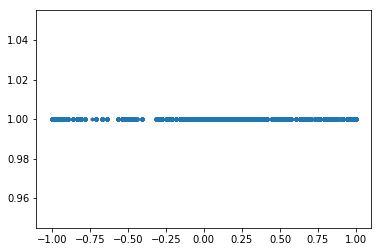

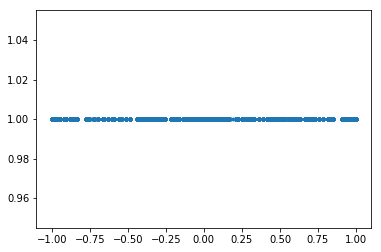

In [192]:
Adata, Adatalength = get_angular_samples(base_dir, "A")
Ldata, Ldatalength = get_angular_samples(base_dir, "L")

In [200]:
Adata[:,1]

array([-3.45578707e-02,  1.00000000e+00, -9.96812615e-01, ...,
       -4.29987304e-04, -2.15039957e-02, -5.26500380e-02])

In [204]:
vmentrya = np.array([[elem] for elem in Adata])
vmentryl = np.array([[elem] for elem in Ldata])
gmmentrya = np.array([[elem] for elem in norm_samplesA])
gmmentryl = np.array([[elem] for elem in norm_samplesL])

In [205]:
from msmbuilder.hmm import VonMisesHMM

n_states = int(np.ceil(np.amin(Adatalength)))
vma = VonMisesHMM(n_states=2, n_iter=1000).fit(vmentrya)
n_states = int(np.ceil(np.amin(Adatalength)))
vml = VonMisesHMM(n_states=2, n_iter=1000).fit(vmentryl)
vma.kappas_
vma.means_

array([[ 0.99180907,  0.02444638],
       [-0.72571796,  0.01452201]], dtype=float32)

In [206]:
vma.kappas_

array([[700.        ,  65.41314559],
       [  4.1727654 ,   4.69496479]])

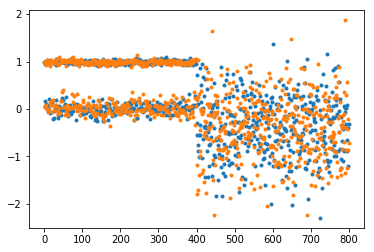

In [207]:

data_ev = []
for x in range(0, 200):
    s = np.random.vonmises(vma.means_[0,0], vma.kappas_[0,0], 2)
    l = np.random.vonmises(vma.means_[0,1], vma.kappas_[0,1], 2)
    data_ev.append(s)
    data_ev.append(l)
    
for x in range(0, 200):
    s = np.random.vonmises(vma.means_[1,0], vma.kappas_[1,0], 2)
    l = np.random.vonmises(vma.means_[1,1], vma.kappas_[1,1], 2)
    data_ev.append(s)
    data_ev.append(l)

plt.plot(data_ev, '.')



"\nkappas1 = np.asarray(vml.kappas_[0])\nkappas2 = np.asarray(vml.kappas_[1])\n\nimport spherecluster as sc\nimport random\nX_0 = sc.sample_vMF(vml.means_[0], kappas1.any(), 1000)\nX_1 = sc.sample_vMF(vml.means_[1], kappas2.any(), 1000)\nX = np.zeros((2 * 1000, 2))\nX[:1000, :] = X_0\nX[1000:, :] = X_1\nlabels = np.zeros((2 * 1000, ))\nlabels[1000:] = 1\nplt.plot(X,'.')\n"

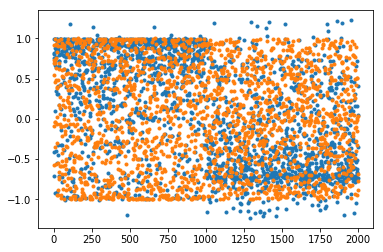

In [208]:

kappas1 = np.asarray(vma.kappas_[0])
kappas2 = np.asarray(vma.kappas_[1])

import spherecluster as sc
import random
X_0 = sc.sample_vMF(vma.means_[0], kappas1.any(), 1000)
X_1 = sc.sample_vMF(vma.means_[1], kappas2.any(), 1000)
X = np.zeros((2 * 1000, 2))
X[:1000, :] = X_0
X[1000:, :] = X_1
labels = np.zeros((2 * 1000, ))
labels[1000:] = 1
plt.plot(X,'.')
'''
kappas1 = np.asarray(vml.kappas_[0])
kappas2 = np.asarray(vml.kappas_[1])

import spherecluster as sc
import random
X_0 = sc.sample_vMF(vml.means_[0], kappas1.any(), 1000)
X_1 = sc.sample_vMF(vml.means_[1], kappas2.any(), 1000)
X = np.zeros((2 * 1000, 2))
X[:1000, :] = X_0
X[1000:, :] = X_1
labels = np.zeros((2 * 1000, ))
labels[1000:] = 1
plt.plot(X,'.')
'''

In [209]:
mu, kappa = 0, 1.0
data_ev = []
for x in range(0, 200):
    s = numpy.random.vonmises(mu, kappa, 2)
    data_ev.append(s)
    
mu, kappa = 3.0, 1.5
for x in range(0, 200):
    s = numpy.random.vonmises(mu, kappa, 2)
    data_ev.append(s)

from random import shuffle
shuffle(data_ev)

NameError: name 'numpy' is not defined

In [210]:
import pandas as pd
from sklearn.cross_validation import KFold
from msmbuilder.hmm import GaussianHMM

n_states = [2, 3, 4, 5]
cv = KFold(len(norm_samplesA), n_folds=5)
results = []

for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [gmmentrya[i] for i in train_index]
        test_data = [gmmentrya[i] for i in test_index]
        gaussiana = GaussianHMM(n_states = n, n_iter=1000).fit(train_data)
        train_score = gaussiana.score(train_data)
        test_score = gaussiana.score(test_data)
        results.append({
            'train_score': train_score,
            'test_score1': test_score,
            'n_states': n,
            #'p' : l,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))
print(avgs)

          test_score1  train_score
n_states                          
2          181.217750   773.879497
3          358.903962  1432.616503
4          432.747968  1775.783071
5          496.190199  2026.186095


In [213]:
results= []
for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [vmentrya[i] for i in train_index]
        test_data = [vmentrya[i] for i in test_index]
        vma = VonMisesHMM(n_states = n, n_iter=1000).fit(train_data)
        train_score = vma.score(train_data)
        test_score = vma.score(test_data)
        results.append({
            'train_score': train_score,
            'test_score2': test_score,
            'n_states': n,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs1 = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))

In [214]:
cv = KFold(len(norm_samplesL), n_folds=5)
results = []

for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [gmmentryl[i] for i in train_index]
        test_data = [gmmentryl[i] for i in test_index]
        gaussianl = GaussianHMM(n_states = n, n_iter=1000).fit(train_data)
        train_score = gaussianl.score(train_data)
        test_score = gaussianl.score(test_data)
        results.append({
            'train_score': train_score,
            'test_score3': test_score,
            'n_states': n,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs2 = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))

In [215]:
results = []
for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [vmentryl[i] for i in train_index]
        test_data = [vmentryl[i] for i in test_index]
        vml = VonMisesHMM(n_states = n, n_iter=1000).fit(train_data)
        train_score = vml.score(train_data)
        test_score = vml.score(test_data)
        results.append({
            'train_score': train_score,
            'test_score3': test_score,
            'n_states': n,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs3 = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))

In [216]:
frames = [avgs, avgs1, avgs2, avgs3]
result = pd.concat(frames,axis =1)
result
print(result)


          test_score1  train_score  test_score2  train_score  test_score3  \
n_states                                                                    
2          181.217750   773.879497   152.366748   600.870012   428.096753   
3          358.903962  1432.616503   416.904407  1692.541077   900.808809   
4          432.747968  1775.783071   476.178824  1879.400422  1117.509483   
5          496.190199  2026.186095   554.449294  2202.597295  1293.256182   

          train_score  test_score3  train_score  
n_states                                         
2         1730.715610   181.711434   801.182406  
3         3525.775039   442.932262  1833.001001  
4         4496.070774   480.435167  2013.148134  
5         5358.758247   553.015042  2245.818766  


In [ ]:
'''%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(results['n_states'], results['train_score'], c='b', marker='.', ls='')
plt.plot(results['n_states'], results['test_score'], c='r', marker='.', ls='')

mean_over_folds = results.groupby('n_states').aggregate(np.mean)
plt.plot(mean_over_folds.index, mean_over_folds['test_score'], c='r', marker='.', ls='-', label='Mean test')
plt.plot(mean_over_folds.index, mean_over_folds['train_score'], c='b', marker='.', ls='-', label='Mean train')
plt.semilogx()
plt.ylabel('Generalized Matrix Rayleigh Quotient (Score)')
plt.xlabel('Number of states')

best_n_states = np.argmax(mean_over_folds['test_score'])
best_test_score = mean_over_folds.ix[best_n_states]['test_score']
plt.plot(best_n_states, best_test_score, marker='*', ms=20, c='w', label='n_states=%d' % best_n_states)

plt.legend(loc='best', numpoints=1)
plt.show()
'''

In [226]:
l = [len(gmmentrya), len(vmentrya), len(gmmentryl), len(vmentryl)]
l1 = pd.Series([len(gmmentrya),len(gmmentrya),len(gmmentrya),len(gmmentrya)], index=[2,3,4,5])
l2 = pd.Series([l[1],l[1],l[1],l[1]], index=[2,3,4,5])
l3 = pd.Series([l[2],l[2],l[2],l[2]], index=[2,3,4,5])
l4 = pd.Series([l[3],l[3],l[3],l[3]], index=[2,3,4,5])


In [231]:
AIC = result
AIC
AIC['len1'] = l1
AIC['len2'] = l2
AIC['len3'] = l3
AIC['len4'] = l4
#del AIC['train_score']
AIC['test_score1'] = (-2 * AIC.test_score1) + 2 * AIC.len1
AIC['test_score2'] = (-2 * AIC.test_score2) + 2 * AIC.len2
#AIC['test_score3'] = (-2 * AIC.test_score3) + 2 * AIC.len3
#AIC['test_score4'] = (-2 * AIC.test_score4) + 2 * AIC.len4

print(AIC)

TypeError: unorderable types: str() < int()